In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [2]:
mean = [0.4915909, 0.4823458, 0.4467193]
std = [0.23832326, 0.23488124, 0.25267875]

In [3]:
train_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
test_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [5]:
trainset = torchvision.datasets.CIFAR10(root='datasets/cifar10/train',
                                        train=True,
                                        download=True,
                                        transform=train_transform)

Files already downloaded and verified


In [6]:
testset = torchvision.datasets.CIFAR10(root='datasets/cifar10/train',
                                       train=False,
                                       download=True,
                                       transform=test_transform)

Files already downloaded and verified


In [7]:
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=16,
                                          shuffle=True,
                                          num_workers=2)

In [8]:
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=16,
                                         shuffle=False,
                                         num_workers=2)

In [9]:
class_names = trainset.classes

print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [10]:
img, label = iter(trainloader).next()

In [11]:
img.shape

torch.Size([16, 3, 32, 32])

In [12]:
label

tensor([1, 2, 9, 8, 3, 1, 0, 4, 0, 7, 9, 1, 0, 9, 9, 5])

In [13]:
in_size = 3
hid1_size = 16
hid2_size = 32
out1_size = 400
out2_size = 10
k_conv_size = 5

In [14]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()

        self.layer1 = nn.Sequential(nn.Conv2d(in_size, hid1_size, k_conv_size),
                                    nn.BatchNorm2d(hid1_size),
                                    nn.ELU(),
                                    #nn.Tanh(),
                                    #nn.Sigmoid(),
                                    #nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2))

        self.layer2 = nn.Sequential(nn.Conv2d(hid1_size, hid2_size, k_conv_size),
                                    nn.BatchNorm2d(hid2_size),
                                    nn.ELU(),
                                    #nn.Tanh(),
                                    #nn.Sigmoid(),
                                    #nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2))

        self.layer3 = nn.Sequential(nn.Linear(hid2_size * k_conv_size * k_conv_size, out1_size),
                                    nn.ELU(),
                                    #nn.Tanh(),
                                    #nn.Sigmoid(),
                                    #nn.ReLU(), 
                                    nn.Dropout(0.5),
                                    nn.Linear(out1_size, out2_size))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.layer3(out)

        return F.log_softmax(out, dim=-1)


In [15]:
model = ConvNet()

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [17]:
model.to(device)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=800, out_features=400, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=400, out_features=10, bias=True)
  )
)

In [18]:
learning_rate = 0.001
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
total_step = len(trainloader)
num_epochs = 10
loss_values = list()

In [20]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 2000 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
            loss_values.append(loss.item())

print('Finished Training')

Epoch [1/10], Step [2000/3125], Loss: 1.3596
Epoch [2/10], Step [2000/3125], Loss: 1.0446
Epoch [3/10], Step [2000/3125], Loss: 1.1114
Epoch [4/10], Step [2000/3125], Loss: 1.2073
Epoch [5/10], Step [2000/3125], Loss: 0.8010
Epoch [6/10], Step [2000/3125], Loss: 1.0291
Epoch [7/10], Step [2000/3125], Loss: 0.9678
Epoch [8/10], Step [2000/3125], Loss: 0.8978
Epoch [9/10], Step [2000/3125], Loss: 1.0234
Epoch [10/10], Step [2000/3125], Loss: 0.7077
Finished Training


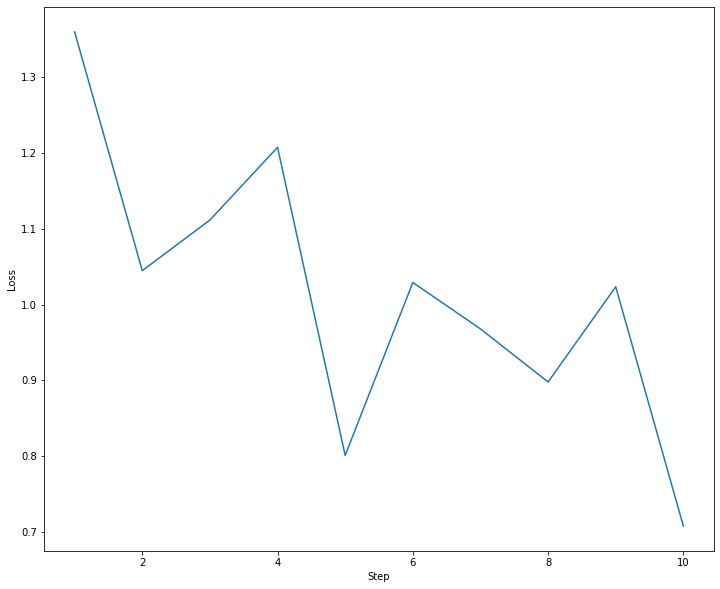

In [21]:
x = (range(1, 11))

plt.figure(figsize=(12, 10))

plt.plot(x, loss_values) 
plt.xlabel('Step')
plt.ylabel('Loss');

In [22]:
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('Accuracy of the model on the 10000 test images: {}%'.format(100 * correct / total))

Accuracy of the model on the 10000 test images: 71.08%


In [23]:
sample_img, _  = testset[23]

In [24]:
sample_img.shape

torch.Size([3, 32, 32])

In [25]:
sample_img = np.transpose(sample_img, (1, 2, 0))

In [26]:
m, M = sample_img.min(), sample_img.max()
sample_img = (1/(abs(m) * M)) * sample_img + 0.5

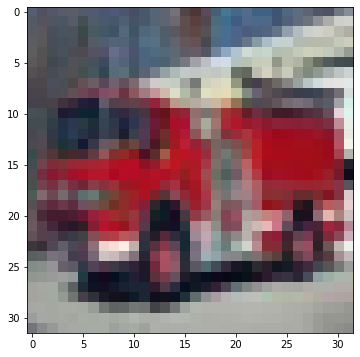

In [27]:
plt.figure(figsize = (6, 6))
plt.imshow(sample_img);

In [28]:
test_img, test_label = testset[23]

test_img = test_img.reshape(-1, 3, 32, 32)

In [29]:
out_predict = model(test_img.to(device))
_, predicted = torch.max(out_predict.data, 1)

In [30]:
print("Actual Label : ", test_label)

Actual Label :  9


In [31]:
print("Class name for {}: {}".format(predicted.item(), class_names[predicted.item()]))

Class name for 9: truck
